## ##################################.py

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn


class Policy_Network(nn.Module):
    def __init__(self, input_size, output_size):
        super(Policy_Network, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x



# Create the environment
env = gym.make("CartPole-v1", render_mode="human")
num_observations = env.observation_space.shape[0]
num_actions = env.action_space.n

# Load the trained model
model = Policy_Network(num_observations, num_actions)
model.load_state_dict(torch.load(r"C:\Users\BYCInfo\Desktop\M2-2.2\machine learning\RL\reinforce_cartpole.pth"))
model.eval()  # Set to evaluation mode

# Reset the environment and get the initial observation
observation, _ = env.reset()

for _ in range(10000):
    obs_tensor = torch.tensor(np.array(observation), dtype=torch.float32).unsqueeze(0) 

    action_probs = model(obs_tensor).squeeze(0).detach().numpy()  # Ensure 1D tensor and detach

    action = np.random.choice(num_actions, p=action_probs)  # Sample action based on probabilities

    observation, reward, terminated, truncated, info = env.step(action)

    env.render()
    
    if terminated or truncated:
        observation, _ = env.reset()  # Reset the environment for the next episode

env.close()

c:\PYTHON\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


: 

In [6]:
import gym
import numpy as np
import torch
import torch.nn as nn

class Policy_Network(nn.Module):
    def __init__(self, input_size, output_size):
        super(Policy_Network, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

Episode 10/500 - Loss: -0.24993574619293213 - Total Reward: 35.0
Episode 20/500 - Loss: -1.2089557647705078 - Total Reward: 21.0
Episode 30/500 - Loss: -1.935943365097046 - Total Reward: 43.0
Episode 40/500 - Loss: -3.147481918334961 - Total Reward: 53.0
Episode 50/500 - Loss: -0.2440059781074524 - Total Reward: 110.0
Episode 60/500 - Loss: 1.5572397708892822 - Total Reward: 187.0
Episode 70/500 - Loss: 1.1141773462295532 - Total Reward: 107.0
Episode 80/500 - Loss: -1.4797956943511963 - Total Reward: 109.0
Episode 90/500 - Loss: 4.44683837890625 - Total Reward: 107.0
Episode 100/500 - Loss: -0.8835690021514893 - Total Reward: 131.0
Episode 110/500 - Loss: -1.2676522731781006 - Total Reward: 282.0
Episode 120/500 - Loss: -1.3242322206497192 - Total Reward: 242.0
Episode 130/500 - Loss: 3.1865692138671875 - Total Reward: 325.0
Episode 140/500 - Loss: 4.358852386474609 - Total Reward: 150.0
Episode 150/500 - Loss: 11.720115661621094 - Total Reward: 321.0
Episode 160/500 - Loss: -6.720347

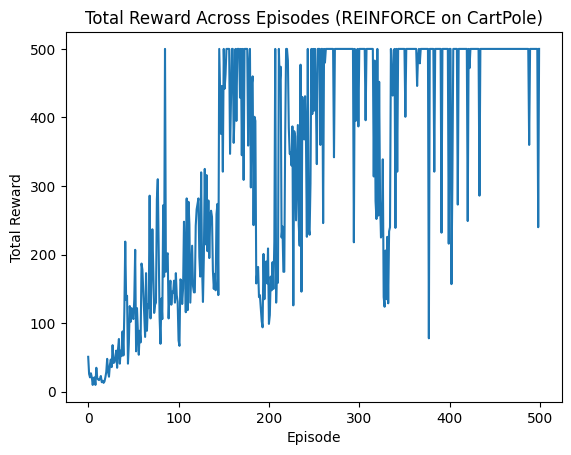

In [10]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Create the environment
env = gym.make("CartPole-v1", render_mode="human") 

num_actions = env.action_space.n
num_observations = env.observation_space.shape[0]

#params
learning_rate = 5e-3
gamma = 0.99  # Discount factor for future rewards
num_episodes = 500

model = Policy_Network(num_observations, num_actions)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Reset the environment and get the initial observation
observation, info = env.reset()

#for plotting
episode_rewards = []

max_time_steps=500

for episode in range(num_episodes):
    rewards =[]
    observation, info = env.reset()
    log_probs = []
    done = False
    total_reward = 0
    time_steps = 0
    while not done and time_steps  < max_time_steps:
        #print(observation)

        obs_tensor = torch.tensor(np.array(observation), dtype=torch.float32).unsqueeze(0) 

        action_probs = model(obs_tensor)
        
        action = np.random.choice(num_actions, p=np.squeeze(action_probs.detach().numpy()))
        log_prob = torch.log(action_probs[0, action])
        log_probs.append(log_prob)
 

        observation, reward, terminated, truncated, info = env.step(action) #(array([ 0.02585303, -0.35200363,  0.03153316,  0.63737667], dtype=float32), 1.0, False, False, {})


        rewards.append(reward)
        total_reward += reward
        time_steps += 1

        if terminated or truncated: 
        # Terminated before max step
           done = True
      
    
    done = True
    # Compute discounted returns using gamma
    returns = []
    discounted_sum = 0

    for r in rewards[::-1]:#calculate the future rewards starting from the end of the episode (start from the end of list)
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize returns
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = torch.tensor(returns, dtype=torch.float32)

    # Compute policy loss
    policy_loss = []
    for log_prob, ret in zip(log_probs, returns):
        policy_loss.append(-log_prob * ret)
    policy_loss = torch.sum(torch.stack(policy_loss))

    # Update the policy
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    # Log the total reward per episode
    episode_rewards.append(total_reward)

    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{num_episodes} - Loss: {policy_loss.item()} - Total Reward: {total_reward}")

# Plot total rewards across episodes
plt.plot(range(num_episodes), episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward Across Episodes (REINFORCE on CartPole)")
plt.savefig("total_rewards.png")
plt.show()

# Save the model
torch.save(model.state_dict(), "reinforce_cartpole.pth")

env.close()